# Занятие 5. Продвинутые методы классификации и регрессии. Переобучение

## Практика. Переобучение, кривые валидации и обучения.

In [109]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
%pylab inline
figsize(12, 8)
import seaborn as sns
from sklearn.svm import SVC
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from sklearn.preprocessing import StandardScaler
import sys
#sys.path.append('../../scripts/')
#from load_titanic_with_features import load_titanic

Populating the interactive namespace from numpy and matplotlib


In [153]:
data_train = pd.read_csv("train.csv")
X_test = pd.read_csv("test.csv")
data_train['Fare'] = data_train.apply(func = (lambda x: 0 if x['Fare'] <= 100 else (1 if x['Fare'] <= 200 and x['Fare'] > 100 else 2 )), axis=1)

In [159]:
data_train[data_train['Survived'] == 1 ]['Fare'].value_counts()

0    303
1     25
2     14
Name: Fare, dtype: int64

In [111]:
y = data_train['Survived']

In [112]:
X_train = data_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]


In [113]:
X_test = X_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]

In [114]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,male,34.5,0,0
1,3,female,47.0,1,0
2,2,male,62.0,0,0
3,3,male,27.0,0,0
4,3,female,22.0,1,1


In [115]:
from sklearn.preprocessing import LabelEncoder

In [116]:
encoder = LabelEncoder()
X_train['Sex'] = encoder.fit_transform(X_train['Sex'])
X_test['Sex'] = encoder.fit_transform(X_test['Sex'])

In [117]:
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].median())

In [118]:
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].median())

In [119]:
def age_group(age):
    if age <= 10:
        return 0
    elif age <=20 and age > 10:
        return 1
    elif age <= 30 and age >20:
        return 2
    elif age <= 40 and age < 30:
        return 3
    elif age <= 50 and age > 40:
        return 4
    elif age <= 60 and age > 50:
        return 5
    elif age > 60:
        return 6

In [130]:
X_test['Age'] = X_test.apply(func=(lambda x: 0 if x['Age'] <= 20 else (1 if x['Age'] <= 40 else (2 if x['Age'] <=60 else 3))), axis=1)



**Отшкалируйте выборку - создайте X_train_scaled и X_test_scaled.**

In [131]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [132]:
def plot_curve(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

In [133]:
def plot_learning_curve(C=1):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(SVC(C=C),
                                                  X_train_scaled, y, train_sizes, cv=5)
    plot_curve(N_train, 1 - val_train, label='training scores')
    plot_curve(N_train, 1 - val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('error')
    plt.ylim(0, 0.4)
    plt.xlim(5, 800)
    plt.legend()

**Посмотрите, как использовать метод validation_curve и получите значения качества при 5-кратной кросс-валидации с SVM на обучающей и тестовой выборках для 100 значений параметра C от $10^{-3}$ до $10^2$.**

In [134]:
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge
from sklearn.svm import SVC

In [135]:
c_values = np.logspace(-3, 2, 100)
val_train, val_test = validation_curve(SVC(), X_train_scaled, y, param_name="gamma", param_range=c_values, cv=5, n_jobs=-1)


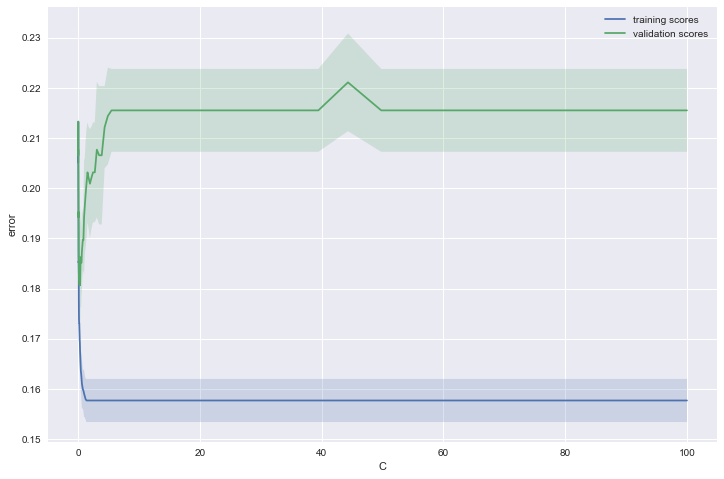

In [136]:
plot_curve(c_values, 1 - val_train, label='training scores')
plot_curve(c_values, 1 - val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('error')
plt.legend();

**Теперь то же самое, но для 100 значений C от 0.05 до 5. Проделайте это для масштабированной и не масштабированной выборки и сравните результаты.**

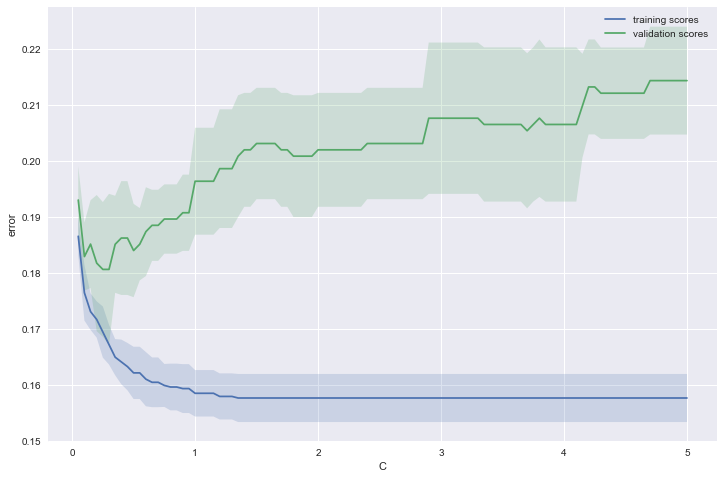

In [137]:
c_values = np.linspace(0.05, 5, 100)
val_train, val_test = validation_curve(SVC(), X_train_scaled, y, param_name="gamma", param_range=c_values, cv=5, n_jobs=-1)
plot_curve(c_values, 1 - val_train, label='training scores')
plot_curve(c_values, 1 - val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('error')
plt.legend();

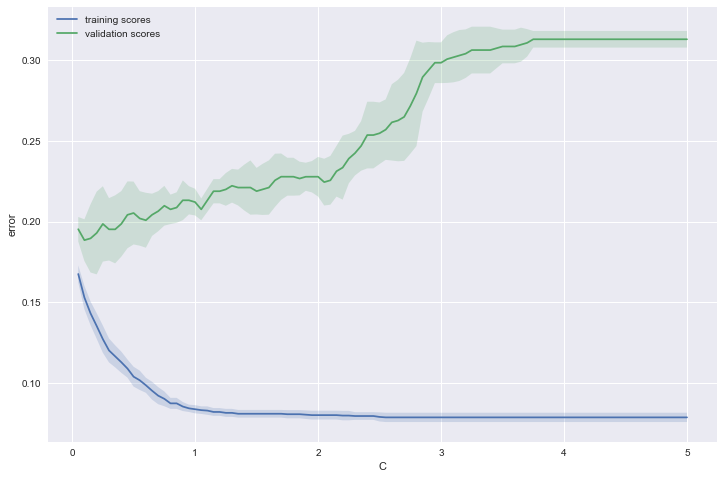

In [66]:
c_values = np.linspace(0.05, 5, 100)
val_train, val_test = validation_curve(SVC(), X_train, y, param_name="gamma", param_range=c_values, cv=5, n_jobs=-1)
plot_curve(c_values, 1 - val_train, label='training scores')
plot_curve(c_values, 1 - val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('error')
plt.legend();

**Найдите оптимальное значение параметра регуляризации C из диапазона от 0.05 до 3 с помощью GridSearchCV.**

In [138]:
from sklearn.grid_search import GridSearchCV

params = {'C': np.linspace(0.05, 3, 100)}
best_clf =  GridSearchCV(SVC(), params, n_jobs=-1, cv=5)

best_clf.fit(X_train_scaled, y)

# print best estimatior and params
print("Best params:", best_clf.best_params_)
print("Best cross validation accuracy", best_clf.best_score_)

Best params: {'C': 1.3611111111111112}
Best cross validation accuracy 0.8204264870931538


**Посмотрите на кривые обучения для значений $C\ 10^{-4}, 10^4$, а также для лучшего найденного с помощью GridSearchCV. Проинтерпретируйте полученные результаты.**

Wall time: 1.49 s


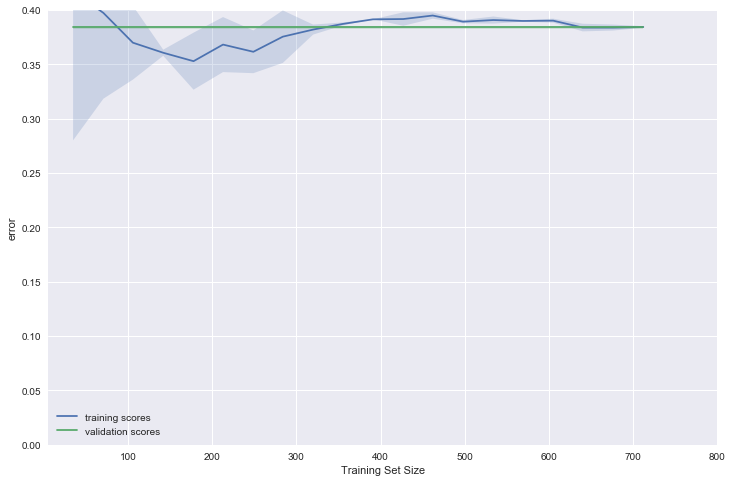

In [48]:
%%time
plot_learning_curve(1e-4)

Wall time: 1.18 s


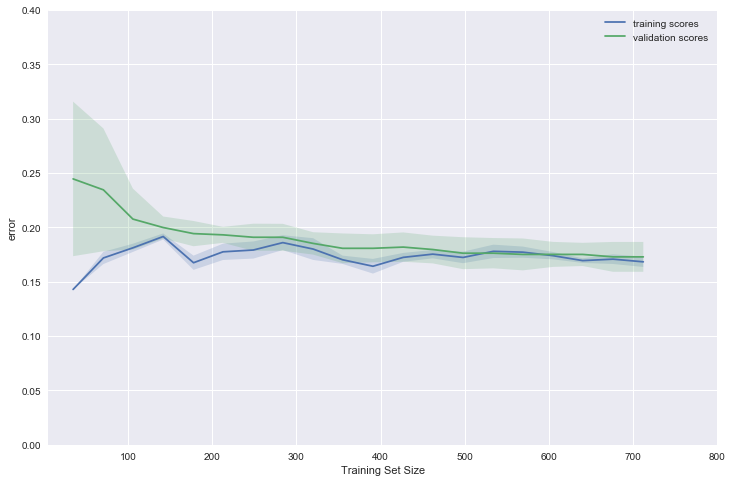

In [50]:
%%time
plot_learning_curve(best_clf.best_params_['C'])

Wall time: 4min 25s


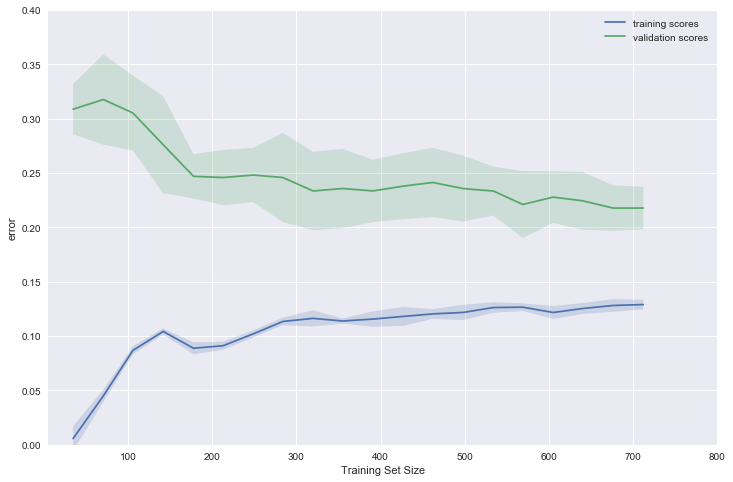

In [106]:
%%time
plot_learning_curve(1e4)

**Запишем ответы в файл и отправим решение на Kaggle.**

In [145]:
data_train['Fare'] = data_train.apply(func = (lambda x: 0 if x['Fare'] <= 50 else (1 if x['Fare'] <= 150 and x['Fare'] > 50 else 2 )), axis=1)

0    731
1    131
2     29
Name: Fare, dtype: int64

In [139]:
# make predictions. This results in 0.7847 LB
predicted_labels = best_clf.predict(X_test_scaled)


In [140]:
def write_to_submission_file(predicted_labels, out_file, train_num=891,
                    target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(train_num + 1,
                                                  train_num + 1 +
                                                  predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [141]:
write_to_submission_file(predicted_labels, 'titanic_SVM_with_title_SCALLED_age_grouped.csv')